## **Analyzing Multilingual Dataset Performance: Per-Language Model Evaluation**

### **Objective:**
    This notebook investigates the performance of pretrained and custom models on multilingual datasets when trained and evaluated separately for each language. By isolating languages, we aim to identify if specific languages pose unique challenges or limitations to model training and inference.

### **Key Steps:**

1. Divide the dataset into separate datasets for each language.
2. Train models (pretrained or custom) on each language-specific dataset.
3. Evaluate and compare the performance across languages.

### **Step 1:  Import Libraries**

In [7]:
# Import required libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import torch

### **Step 2: Load the Dataset**

Load the multilingual dataset and identify the unique languages for splitting.

In [8]:
# Load the dataset
data = pd.read_csv("../data/train.csv")

# Extract unique languages
languages = data["language"].unique()
print(f"Languages in the dataset: {languages}")

Languages in the dataset: ['English' 'French' 'Thai' 'Turkish' 'Urdu' 'Russian' 'Bulgarian' 'German'
 'Arabic' 'Chinese' 'Hindi' 'Swahili' 'Vietnamese' 'Spanish' 'Greek']


### **Step 3: Split Dataset by Language**

Save the data for each language into separate files for language-specific training and evaluation.

In [9]:
# Create a directory to store language-specific datasets
os.makedirs("language_datasets", exist_ok=True)

# Save each language's data into a separate file
for language in languages:
    lang_data = data[data["language"] == language]
    lang_data.to_csv(f"language_datasets/{language}_data.csv", index=False)
    print(f"Saved {len(lang_data)} samples for {language}")

Saved 6870 samples for English
Saved 390 samples for French
Saved 371 samples for Thai
Saved 351 samples for Turkish
Saved 381 samples for Urdu
Saved 376 samples for Russian
Saved 342 samples for Bulgarian
Saved 351 samples for German
Saved 401 samples for Arabic
Saved 411 samples for Chinese
Saved 374 samples for Hindi
Saved 385 samples for Swahili
Saved 379 samples for Vietnamese
Saved 366 samples for Spanish
Saved 372 samples for Greek


### **Step 4: Initialize Multiple Pre-Trained Models**

Define a list of model names and loop through them during the evaluation process.

In [10]:
# Define a list of pre-trained models to test
model_names = [
    "paraphrase-multilingual-MiniLM-L12-v2",
    "xlm-roberta-large",
    "LaBSE",
    "all-distilroberta-v1",
    "xlm-r-distilroberta-base-paraphrase-v1"
]

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Models to test: {', '.join(model_names)}")

Models to test: paraphrase-multilingual-MiniLM-L12-v2, xlm-roberta-large, LaBSE, all-distilroberta-v1, xlm-r-distilroberta-base-paraphrase-v1


### **Step 5: Train and Evaluate for Each Model and Language**

For each pre-trained model, loop through each language dataset and perform training and evaluation. Save the results for all models.

In [11]:
results = []  # To store evaluation results for all models

# Loop through each model
for model_name in model_names:
    print(f"\nProcessing model: {model_name}")
    safe_model_name = model_name.replace("/", "_").replace(" ", "_")  # File-safe model name

    # Load the Sentence Transformer model
    model = SentenceTransformer(model_name, device=device)
    print(f"Loaded model: {model_name}")

    # Loop through each language dataset
    for language in languages:
        print(f"  Processing language: {language}")

        try:
            # Load the language-specific dataset
            lang_data = pd.read_csv(f"language_datasets/{language}_data.csv")
            
            # Split data into training and validation sets
            pairs = list(zip(lang_data["premise"], lang_data["hypothesis"]))
            labels = lang_data["label"].values
            train_pairs, val_pairs, train_labels, val_labels = train_test_split(
                pairs, labels, test_size=0.2, random_state=42
            )

            # Compute embeddings for training and validation data
            train_embeddings = model.encode(train_pairs, convert_to_tensor=True, batch_size=16)
            val_embeddings = model.encode(val_pairs, convert_to_tensor=True, batch_size=16)

            # Train Logistic Regression classifier
            classifier = LogisticRegression(max_iter=500)
            classifier.fit(train_embeddings.cpu(), train_labels)

            # Evaluate on validation data
            val_predictions = classifier.predict(val_embeddings.cpu())
            val_accuracy = accuracy_score(val_labels, val_predictions)

            # Store results
            results.append({"model": model_name, "language": language, "accuracy": val_accuracy})
            print(f"    Validation Accuracy for {language}: {val_accuracy:.4f}")
        except Exception as e:
            print(f"    Error processing {language}: {e}")


Processing model: paraphrase-multilingual-MiniLM-L12-v2
Loaded model: paraphrase-multilingual-MiniLM-L12-v2
  Processing language: English
    Validation Accuracy for English: 0.4629
  Processing language: French
    Validation Accuracy for French: 0.2949
  Processing language: Thai
    Validation Accuracy for Thai: 0.3867
  Processing language: Turkish
    Validation Accuracy for Turkish: 0.4225
  Processing language: Urdu
    Validation Accuracy for Urdu: 0.4286
  Processing language: Russian
    Validation Accuracy for Russian: 0.3947
  Processing language: Bulgarian
    Validation Accuracy for Bulgarian: 0.4493
  Processing language: German
    Validation Accuracy for German: 0.2817
  Processing language: Arabic
    Validation Accuracy for Arabic: 0.3457
  Processing language: Chinese
    Validation Accuracy for Chinese: 0.4458
  Processing language: Hindi
    Validation Accuracy for Hindi: 0.3067
  Processing language: Swahili
    Validation Accuracy for Swahili: 0.4026
  Process

No sentence-transformers model found with name xlm-roberta-large. Creating a new one with mean pooling.


    Validation Accuracy for Greek: 0.3467

Processing model: xlm-roberta-large
Loaded model: xlm-roberta-large
  Processing language: English


/home/yazata/venvs/ai_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    Validation Accuracy for English: 0.4716
  Processing language: French
    Validation Accuracy for French: 0.3846
  Processing language: Thai
    Validation Accuracy for Thai: 0.2800
  Processing language: Turkish
    Validation Accuracy for Turkish: 0.4085
  Processing language: Urdu
    Validation Accuracy for Urdu: 0.3636
  Processing language: Russian
    Validation Accuracy for Russian: 0.2763
  Processing language: Bulgarian
    Validation Accuracy for Bulgarian: 0.2609
  Processing language: German
    Validation Accuracy for German: 0.2676
  Processing language: Arabic
    Validation Accuracy for Arabic: 0.3580
  Processing language: Chinese
    Validation Accuracy for Chinese: 0.3976
  Processing language: Hindi
    Validation Accuracy for Hindi: 0.3733
  Processing language: Swahili
    Validation Accuracy for Swahili: 0.3247
  Processing language: Vietnamese
    Validation Accuracy for Vietnamese: 0.4342
  Processing language: Spanish
    Validation Accuracy for Spanish: 

### **Step 6: Save and Plot the Results**

Combine the results for all models and plot accuracy per language for comparison.

Results saved to results_all_models.csv


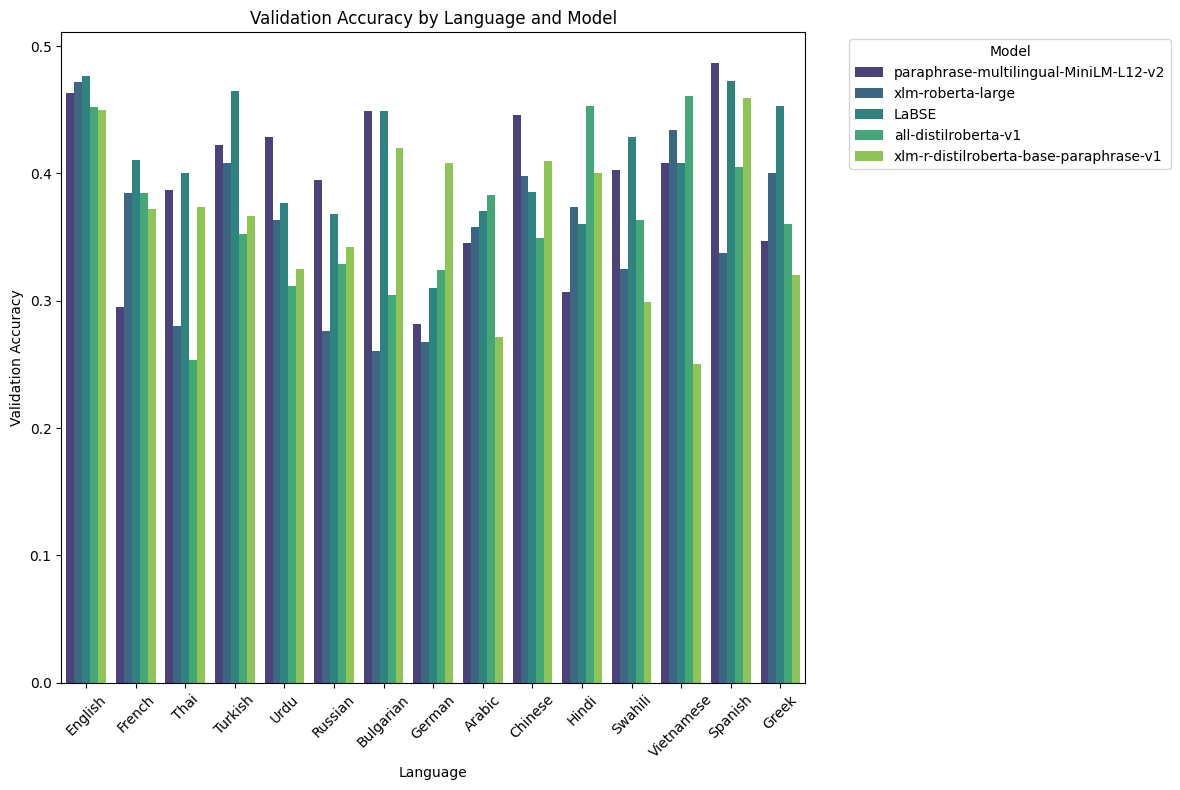

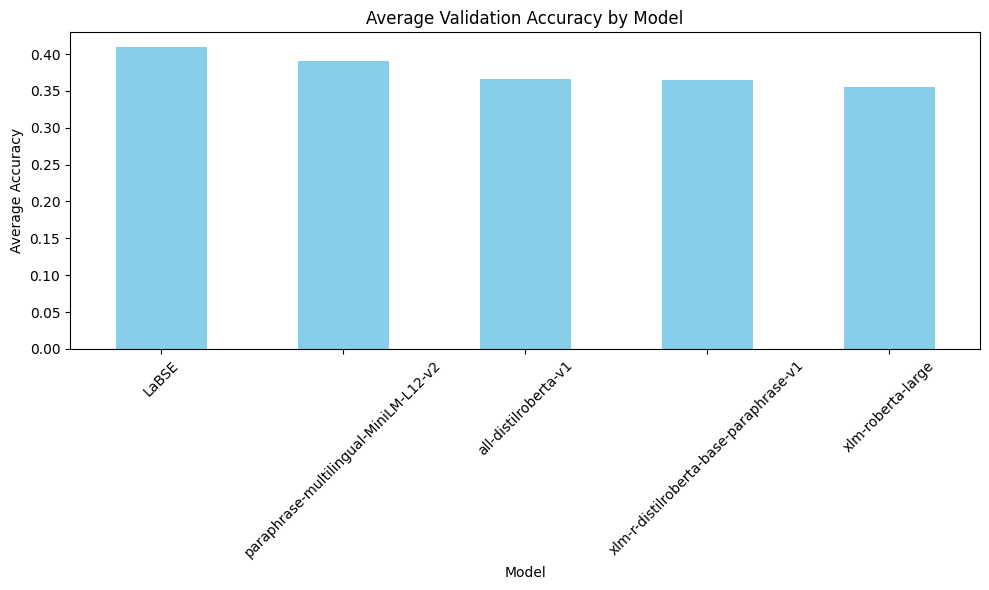

In [12]:
# Save results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("results_all_models.csv", index=False)
print("Results saved to results_all_models.csv")

# Plot accuracy per language for all models
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x="language", y="accuracy", hue="model", palette="viridis")
plt.title("Validation Accuracy by Language and Model")
plt.xlabel("Language")
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("validation_accuracy_by_language_and_model.png")
plt.show()

# Plot average accuracy per model
avg_accuracy = results_df.groupby("model")["accuracy"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_accuracy.plot(kind="bar", color="skyblue")
plt.title("Average Validation Accuracy by Model")
plt.xlabel("Model")
plt.ylabel("Average Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("average_accuracy_by_model.png")
plt.show()

### **Step 7: Conclusions**

- The model seem to perform equally well for most languages
- The model seems to have the highest accuracy for English and Spanish
- For French and German the model has the lowest performance
- Possibly the complexity of the grammer for the former languages could be the reason for low performance
- Despite English having substantially more datapoints than other, this does not seems to affect the performance.